In [1]:
#First tradingEnv class
#todo add transaction cost
# add MACD indicator
# add RSI indicator
# add SMA indicator
# add EMA indicator
# meerdere crypto's toevoegen ( momenteel alleen BTC)
import numpy as np
import pandas as pd
class TradingEnv():
    def __init__(self, initial_investment=20000, Terminal_state= 2000):
        #investment
        self.initial_investment = initial_investment #initial investment 
        self.Terminal_state = Terminal_state  #terminal state, when the agent reach this state or below, the episode is over
        self.current_investment = initial_investment #current investment in a certain state
        self.non_invested = initial_investment #non invested money in a certain state
        self.invested = 0
        self.worth_history = [] #worth history in a certain episode
        # self.invested = [{'amount': 0, 'price_investment': 0, 'timestamp' : UNIX timestamp of investment}] #invested money 
        self.invested_amount = 0
        
        #rewards
        self.current_reward = 0 #current reward in a certain state
        self.total_reward = 0   #total reward in a certain episode
        self.reward_history = [] #reward history in a certain episode
        self.iterations = 0

        #states
        self.current_price = [0,0,0,0] #current price in a certain state [open,high,low,close]
        self.prev_price = np.zeros(20) #previous 20 prices to keep in memory to the state values
        self.done = False #if the episode is over
        self.current_unix_time = 0 #current unix time in a certain state
        self.macd = 0 #macd indicator
        
        
        #actions
        self.action = 0 #chosen action in a certain state
        self.action_history = [] #action history in a certain episode
        self.action_space = np.array([0,1,2]) #action space, 0 = hold, 1 = buy, 2 = sell first in the array 

        #Current state
        # self.current_state = self.get_current_state() #current state
        self.csv_to_dataframe() #convert csv's to one dataframe
        self.csv_index = 0 #index of the csv dataframe


    def get_current_state(self):
        #return current state price, and invested/non invested values as state
        return [self.current_price[0],self.current_price[1],self.current_price[2],self.current_price[3], self.invested, self.non_invested, self.invested_amount, self.current_unix_time, self.macd,self.sma10,self.sma20]
    # def calculate_macd(self):
    #     #calculate macd indicator
    #     print("macd")
    #     # print(self.df.iloc[self.csv_index - 12 : self.csv_index, 3])
    #     # print(self.df.iloc[self.csv_index - 12 : self.csv_index, 3].ewm(span=12, adjust=False).mean())
    #     macd = self.df.iloc[self.csv_index - 500 : self.csv_index, 3].ewm(span=500, adjust=False).mean()
    #     macd = macd.tolist()
    #     print('res',macd)
    #     # print('res',type(macd.tolist()))
    #     print("average macd", sum(macd) / len(macd))

        return macd
    def reset(self):
        #reset the environment
        self.worth_history = []
        self.current_investment = self.initial_investment
        self.current_reward = 0
        self.total_reward = 0
        self.reward_history = []
        self.current_price = [0,0,0,0] #current price in a certain state [open,high,low,close]
        self.invested_amount = 0
        self.non_invested = self.initial_investment #non invested money in a certain state
        self.invested = 0
        self.worth_history = [] #worth history in a certain episode

        self.prev_price = np.zeros(20)
        self.action = 0
        self.action_history = []
        self.done = False
        self.current_unix_time = 0 #current unix time in a certain state
        self.csv_index = 0 #index of the csv dataframe


        #begin somewhere random in csv data 
        
        self.csv_index = np.random.randint(0, (len(self.df)/2) + 20000)
        #get row csv_index from self.df
        self.current_price = self.df.iloc[self.csv_index, 3:7].values
        self.current_unix_time = self.df.iloc[self.csv_index, 0]
        
        self.macd =  self.df.iloc[self.csv_index, 10]
        self.sma20 =  self.df.iloc[self.csv_index, 9]
        self.sma10 =  self.df.iloc[self.csv_index, 11]






        return self.get_current_state(), self.done

    def step(self, action, interval = 1):
        self.iterations += 1
        self.action = action
        self.action_history.append(self.action)
        
        #calculate current reward
        self.current_reward = self.get_reward()
        self.done = self.is_done()
        #if the episode is over, give a big negative reward
        if self.done == True:
            self.current.reward - 1000000

        self.total_reward += self.current_reward
        self.reward_history.append(self.current_reward)

        #get next line of data in csv
        if self.csv_index < len(self.df) - 1:
            self.csv_index += interval
            self.current_price = self.df.iloc[self.csv_index, 3:7].values
            self.current_unix_time = self.df.iloc[self.csv_index, 0]
            self.macd =  self.df.iloc[self.csv_index, 10]
            self.sma20 =  self.df.iloc[self.csv_index, 9]
            self.sma10 =  self.df.iloc[self.csv_index, 11]

        else:
            self.done = True
        return self.get_current_state(), self.current_reward, self.done
        
    def get_reward(self):
        #reward function
        if self.action == 0:
            #hold do nothing
            reward = 0
        elif self.action == 1:
            #buy = invest 1/10 of non_invested money
            to_invest = self.non_invested / 10
            self.non_invested -= to_invest
            amount = to_invest / self.current_price[0]
            self.invested += to_invest
            self.invested_amount += amount
            reward = 0
        elif self.action == 2:
            #sell first bought in array of invested
            if self.invested > 0:
                amount = self.invested_amount
                price_investment = self.invested
                self.non_invested += amount * self.current_price[0]
                self.invested_amount = 0
                self.invested = 0

                reward = (amount * self.current_price[0]) - price_investment
            else:
                #hold, do nothing, nothing to sell
                reward = 0
        
        self.worth_history.append(self.calc_current_worth())
        return reward**3


    def is_done(self):
        #terminal state
        if self.calc_current_worth() <= self.Terminal_state:
            return True
        else:
            return False

    def calc_current_worth(self):
        #calculate current worth
        return self.invested_amount * self.current_price[0] + self.non_invested

        
    def csv_to_dataframe(self):
        #convert csv's to one dataframe
        df2017 = pd.read_csv('./data/BTC-2017min.csv')
        df2018 = pd.read_csv('./data/BTC-2018min.csv')
        df2019 = pd.read_csv('./data/BTC-2019min.csv')
        df2020 = pd.read_csv('./data/BTC-2020min.csv')
        df2021 = pd.read_csv('./data/BTC-2021min.csv')

        #concat all dataframes
        df = pd.concat([df2017, df2018, df2019, df2020, df2021], ignore_index=True)
        #add new column named macd, that is the mean of the last 12 open values
        df['sma20000'] = df['open'].rolling(window=20000).mean()
        self.df = df
        df['macd20000'] = df['open'].rolling(window=20000).mean()**2
        self.df = df
        df['sma10000'] = df['open'].rolling(window=20000).mean()
        self.df = df
        #len = 2675301

c:\Users\cedri\anaconda3\envs\ResearchProj\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


episode:  0 worth: 36481.74 avg score 22966390243354.80
1buy&sell: startworth: 20000 endworth: 28913.64508383306
episode:  1 worth: 8691.15 avg score 11448852603405.01
1buy&sell: startworth: 20000 endworth: 6986.205231145388
episode:  2 worth: 26375.53 avg score 7639519723438.81
1buy&sell: startworth: 20000 endworth: 28186.60553094996


c:\Users\cedri\anaconda3\envs\ResearchProj\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\cedri\AppData\Local\Temp\ipykernel_21732\816332280.py:278: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


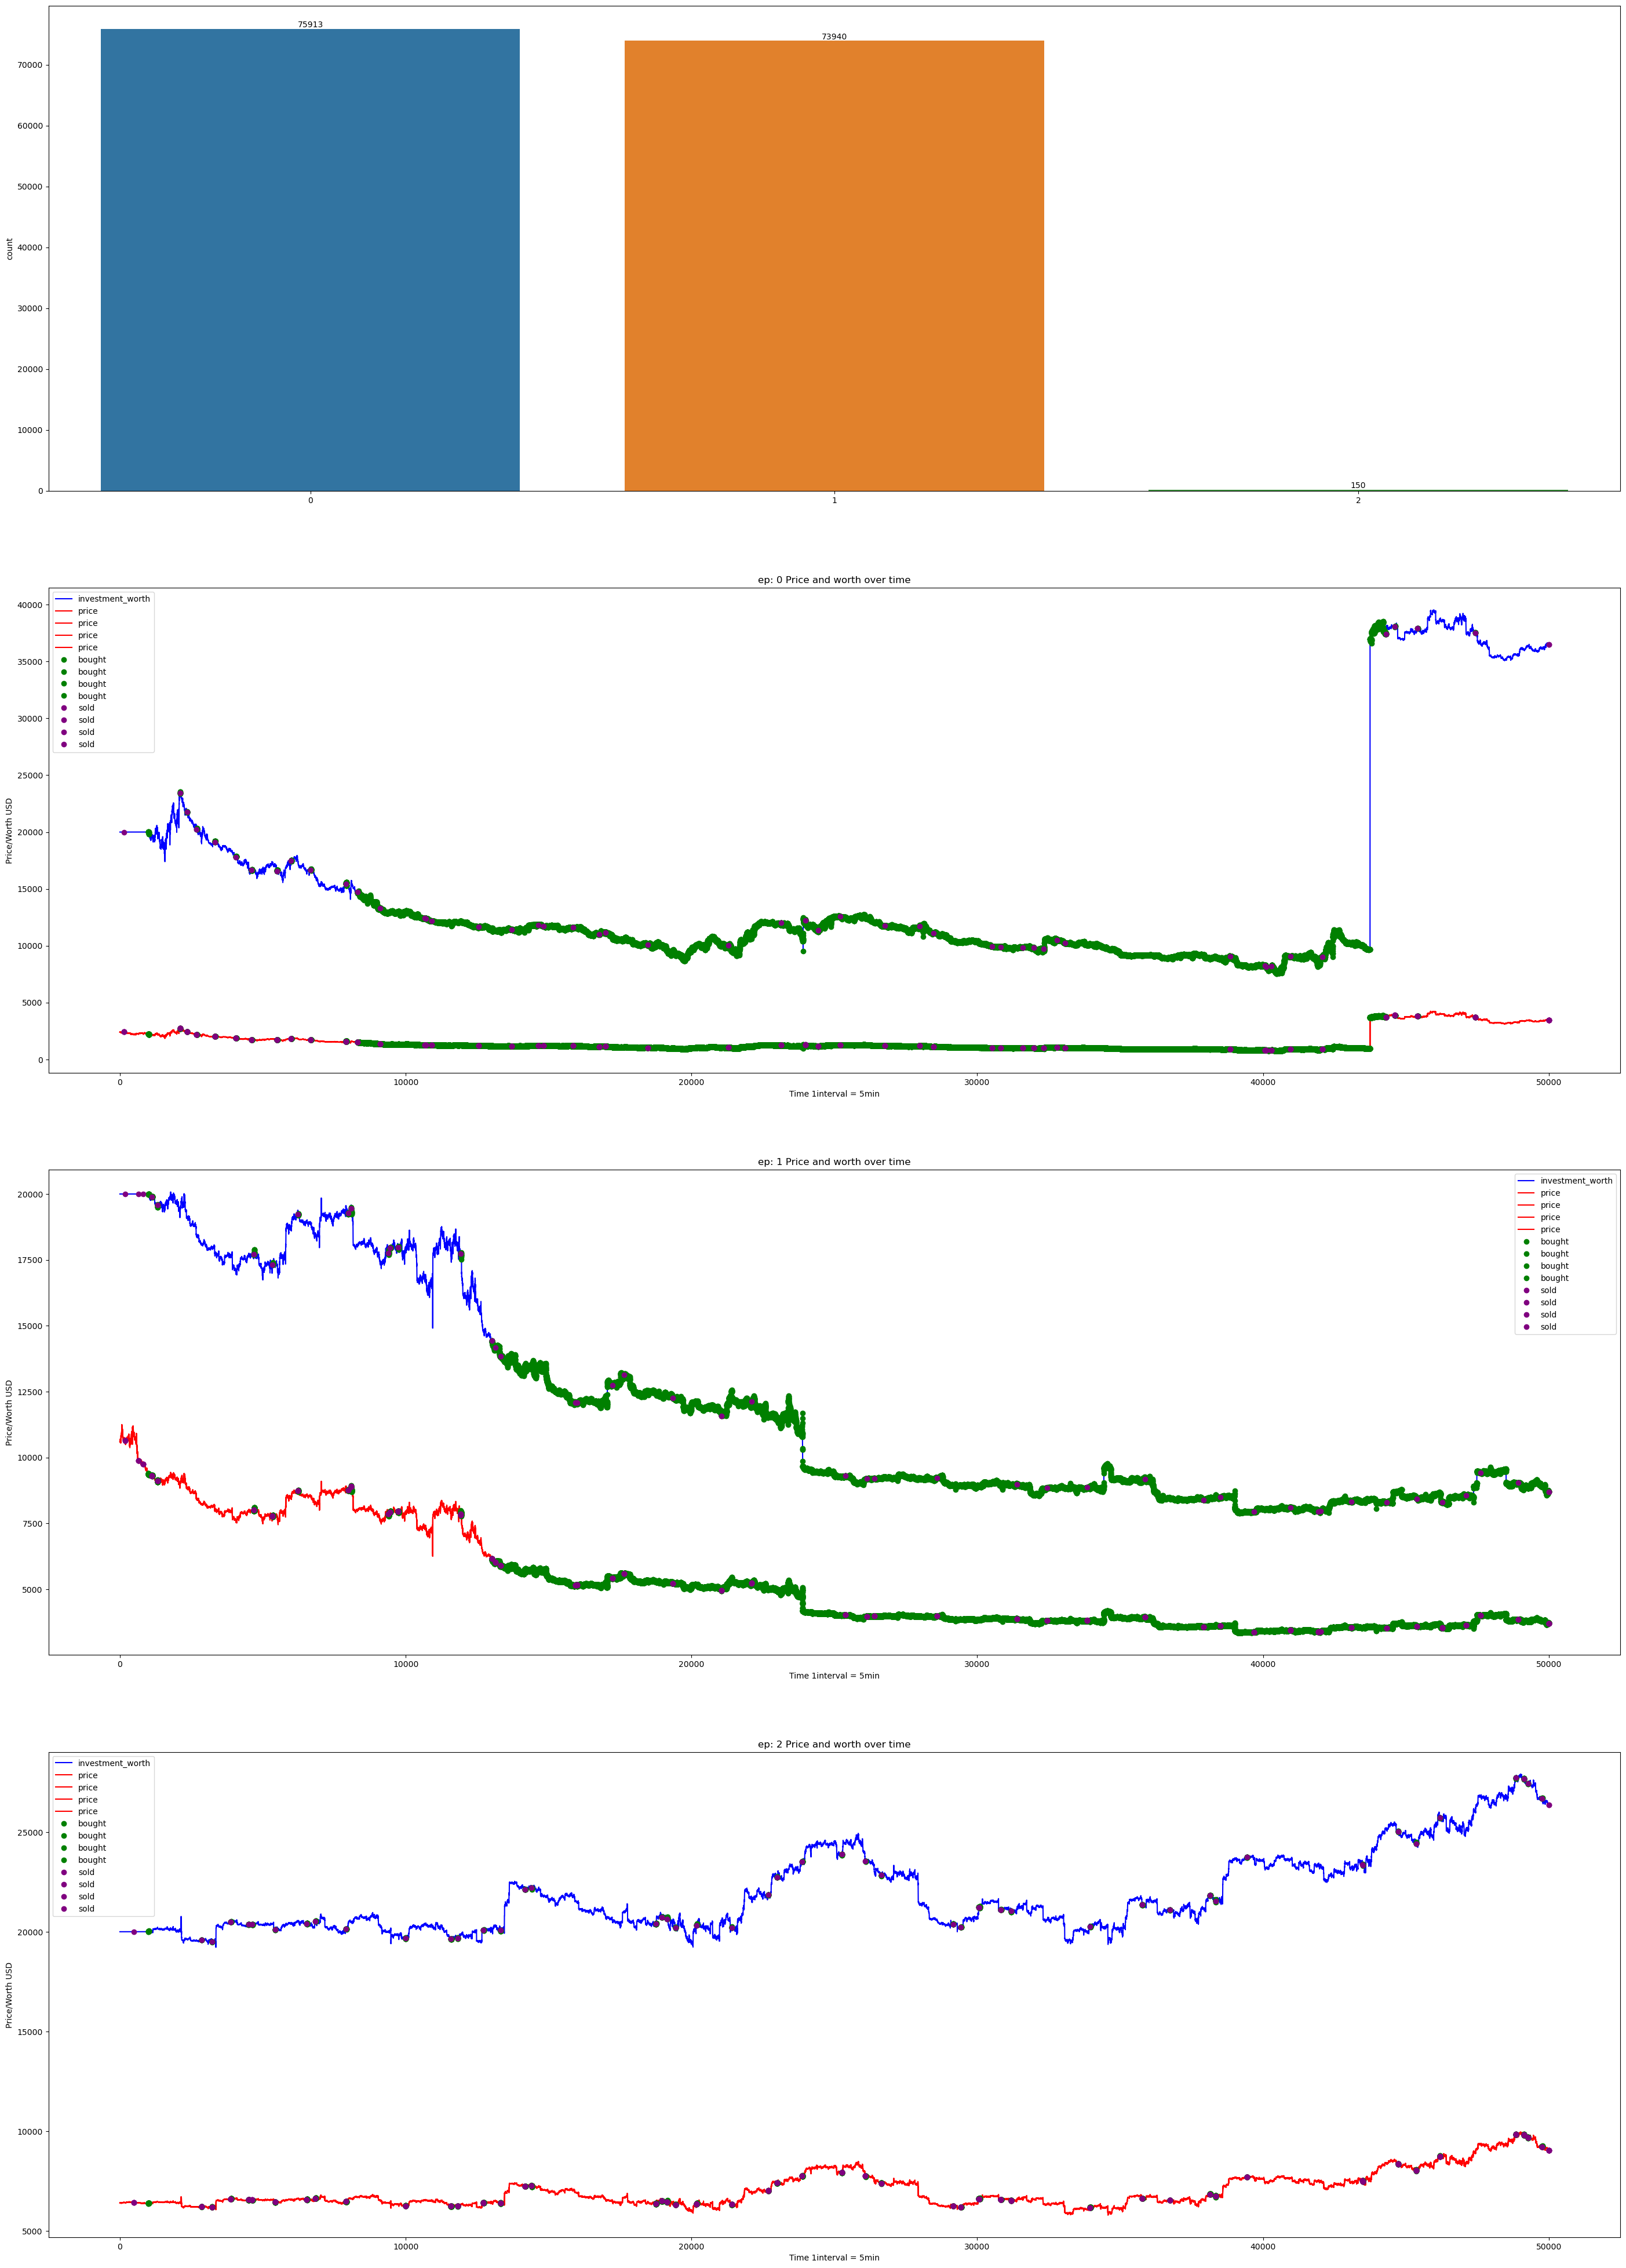

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np

import gym, os
from gym import wrappers

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.get_logger().setLevel('ERROR')
tf.config.experimental_run_functions_eagerly(False)
import pandas as pd
import numpy as np

import keras
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.generic_utils import get_custom_objects

import keras
class Agent(object):
    def __init__(self, alpha, beta, gamma=0.99, n_actions=3,
                 layer1_size=1024, layer2_size=512, input_dims=11):
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.input_dims = input_dims
        self.fc1_dims = layer1_size
        self.fc2_dims = layer2_size
        self.n_actions = n_actions
        # hier nieuw netwerk maken of oude inladen
        # self.actor, self.critic, self.policy = self.build_actor_critic_network()
        self.critic = keras.models.load_model('BTC5minbigreward/critic')
        self.policy = keras.models.load_model('BTC5minbigreward/policy')
        self.actor = load_model('BTC5minbigreward/actor')
        
        self.action_space = [i for i in range(n_actions)]
    # def custom_loss(self,y_true, y_pred):
    #     out = K.clip(y_pred, 1e-8, 1-1e-8)
    #     log_lik = y_true*K.log(out)
    #     delta = Input(shape=[1])
    #     return K.sum(-log_lik* Input(shape=[1]))

    def build_actor_critic_network(self):
        NN_input = Input(shape=(self.input_dims,))
        delta = Input(shape=[1])
        dense1 = Dense(self.fc1_dims, activation='relu')(NN_input)
        dense2 = Dense(self.fc2_dims, activation='relu')(dense1)
        probs = Dense(self.n_actions, activation='softmax')(dense2)
        values = Dense(1, activation='linear')(dense2)

        

        actor = Model(inputs=[NN_input, delta], outputs=[probs])

        actor.compile(optimizer=Adam(lr=self.alpha), loss='categorical_crossentropy')

        critic = Model(inputs=[NN_input], outputs=[values])

        critic.compile(optimizer=Adam(lr=self.beta), loss='mean_squared_error')

        policy = Model(inputs=[NN_input], outputs=[probs])

        return actor, critic, policy

    def choose_action(self, observation):
        try:    
            state = observation[np.newaxis, :]
            probabilities = self.policy.predict(state)[0]
            action = np.random.choice(self.action_space, p=probabilities)
            return action

        except Exception as ex:
            print("ex: ", ex)
            print(probabilities)
            return 0


    def learn(self, state, action, reward, state_, done):
        state = state[np.newaxis,:]
        state_ = state_[np.newaxis,:]
        critic_value_ = self.critic.predict(state_)
        critic_value = self.critic.predict(state)

        target = reward + self.gamma*critic_value_*(1-int(done))
        delta =  target - critic_value

        actions = np.zeros([1, self.n_actions])
        actions[np.arange(1), action] = 1

        self.actor.fit([state, delta], actions, verbose=0)

        self.critic.fit(state, target, verbose=0) 
        
        
        
        
def train():
    agent = Agent(alpha=0.01, beta=0.05)

    env = TradingEnv()
    score_history = []
    
    steps = []
    
    num_episodes = 3
    fullcounter = 0
    maxIterations = 50000
    allEpisodesWorth = []
    allEpisodesPrice = []
    AllEpisodesSold = []
    AllEpisodesBought = []


    for i in range(num_episodes):
        agent.policy.save('BTC5minbigreward/policy')
        agent.critic.save('BTC5minbigreward/critic')
        agent.actor.save('BTC5minbigreward/actor')
        worth_history = []
        price_history = []
        bought = []
        sold = []
        done = False
        score = 0
        observation, done = env.reset()
        observation = np.asarray(observation)
        counter = 0
        lastBuy = -9000
        lastSold = -9999
        startprice = observation[0]
        while not done:
            counter += 1
            fullcounter += 1
            # env.render()
            action = agent.choose_action(observation)
            
            if action == 1:
                if counter - lastBuy > 100 and counter - lastSold > 100:

                    action = 1
                    lastBuy = counter
                else:
                    action = 0
            if counter - lastBuy > 10000:
                action = 1
            elif action == 2:
                if counter - lastBuy > 200:
                    action = 2
                else:
                    action = 0
            if counter > maxIterations:
                action = 2
                sold.append(counter-1)
            if env.invested > 15000 and action == 1: 
                action = 0
            # pick a number between 0 and 1
            # if the number is less than epsilon, pick a random action
            # if the number is greater than epsilon, pick the action with the highest q value
            if np.random.random() < .001:
                action = 2
            steps.append(action)
            if action == 1:
                bought.append(counter-1)
            elif action == 2:
                sold.append(counter-1)


            observation_, reward, done = env.step(action, interval=5)
            if action == 2:
                # print("reward", reward,"action: ", action ," Episode: ", i, "Step: ", counter, "current_worth: ", env.calc_current_worth())
                pass
                
            observation_ = np.asarray(observation_)
            agent.learn(observation, action, reward, observation_, done)
            observation = observation_
            score += reward
            worth_history.append(env.calc_current_worth())
            price_history.append(env.current_price)
            if counter > maxIterations:
                done = True
        endprice = observation[0]
        allEpisodesWorth.append(worth_history)
        allEpisodesPrice.append(price_history)
        AllEpisodesSold.append(sold)
        AllEpisodesBought.append(bought)

        score_history.append(score)
        avg_score = np.mean(score_history[-100:])
        print('episode: ', i,'worth: %.2f' % env.calc_current_worth(),
              'avg score %.2f' % avg_score)
        print("1buy&sell: startworth:", 20000, "endworth:", (20000/startprice)*endprice)

    # save model progress
    agent.policy.save('BTC5minbigreward/policy')
    agent.critic.save('BTC5minbigreward/critic')
    agent.actor.save('BTC5minbigreward/actor')
    #make axes for 4 plots under eachother
    # print("allEpisodesWorth", len(allEpisodesWorth[0]))
    # print("allEpisodesPrice", len(allEpisodesPrice[0]))
    # print("AllEpisodesSold", len(AllEpisodesSold[0]))
    # print("AllEpisodesBought", len(AllEpisodesBought[0]))
    # print("startprice", startprice)
    # print("endprice", endprice)

    fig, axs = plt.subplots(len(allEpisodesWorth)+1, 1, figsize=(35, 50))
    #plot the price on first axis
    plot = sns.countplot(steps, ax=axs[0])
    plot.bar_label(plot.containers[0])
    #set plotje on first axis
    # sns.lineplot(price_history,ax=axs[3], color="red", label="price")
    # sns.lineplot(worth_history,ax=axs[3], color="blue", label="investment_worth")


    # axs[1].plot(price_history)


    # axs[1].plot(price_history, color="red", label="price")
    # axs[1].plot(worth_history, color="blue", label="investment_worth")
    # #print shapes of bought and sold worth_history and price_history
    # if len(bought) > 0:
    #     axs[1].plot(bought, [worth_history[i] for i in bought], 'o', color='green')
    #     axs[1].plot(bought, [price_history[i] for i in bought], 'o', color='green', label="bought")
    # if len(sold) > 0:
    #     axs[1].plot(sold, [worth_history[i] for i in sold], 'o', color='pink')
    #     axs[1].plot(sold, [price_history[i] for i in sold], 'o', color='pink', label="sold")

    # axs[1].legend()
    # axs[1].set_title("Price and worth over time")
    # axs[1].set_xlabel("Time")
    # axs[1].set_ylabel("Price/Worth")
    #foreach episode plot the worth and price in one plot 
    for i in range(len(allEpisodesWorth)):
        axs[i+1].plot(allEpisodesWorth[i], color="blue", label="investment_worth")
        axs[i+1].plot(allEpisodesPrice[i], color="red", label="price")
        #print shapes of bought and sold worth_history and price_history
        try:
            if len(AllEpisodesBought[i]) > 0:
                axs[i+1].plot(AllEpisodesBought[i], [allEpisodesWorth[i][j] for j in AllEpisodesBought[i]], 'o', color='green')
                axs[i+1].plot(AllEpisodesBought[i], [allEpisodesPrice[i][j] for j in AllEpisodesBought[i]], 'o', color='green', label="bought")
            else:
                print("no bought")
            if len(AllEpisodesSold[i]) > 0:
                axs[i+1].plot(AllEpisodesSold[i], [allEpisodesWorth[i][j] for j in AllEpisodesSold[i]], 'o', color='purple')
                axs[i+1].plot(AllEpisodesSold[i], [allEpisodesPrice[i][j] for j in AllEpisodesSold[i]], 'o', color='purple', label="sold")
            else:
                print("no sold")
        except Exception as ex:
            print("error")
            print(ex)
            print(AllEpisodesBought[i])
            print(AllEpisodesSold[i])
            print(len(allEpisodesWorth[i]))
            print(len(allEpisodesPrice[i]))
            print(allEpisodesWorth[i])
            print(allEpisodesPrice[i])
            print("end error")
            break

        axs[i+1].legend()
        axs[i+1].set_title(f"ep: {i} Price and worth over time")
        axs[i+1].set_xlabel("Time 1interval = 5min")
        axs[i+1].set_ylabel("Price/Worth USD")

       

    fig.show()


        

train()
